# PCA

In this case we build a WuHan corona virus reference graph.
_(Not an actual reference graph because I use reads from only one sample but it works for this example.)_
The question I'm trying to answer is.  
Can we tell the difference between ebola reads mapped to the reference graph and wuhan corona virus reads mapped to the graph?  
This helps answer the more abstract question: can the graph differentiate two different viruses.  
This is the first level of testing whether the graph actually "works".

The generation of the graph, simulation of the reads and mapping is explained here [here](https://github.com/urbanslug/genome-graph-notes/blob/master/Projects/Overall/README.org).

We have two sets of (synthetic) reads:
 1. From Corona Virus
 2. From Ebola virus
 
These reads are then mapped to a Wuhan pangenome reference graph.
The result of this mapping from, vg map, is in the form of a coverage vector in CSV.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-whitegrid')
%matplotlib inline

## Get the data

### Wuhan Corona Virus

In [3]:
wuhan_data = pd.read_csv('data/WHUCoV.pack.table', 
                       sep='\t', 
                       lineterminator='\n')

### Ebola

In [4]:
ebola_data = pd.read_csv('data/ebola.pack.table', 
                       sep='\t', 
                       lineterminator='\n')

## Visualize the coverage

Visualize coverage in a manhattan plot of node id and the coverage.

### WuHan Corona Virus

Text(0, 0.5, 'coverage')

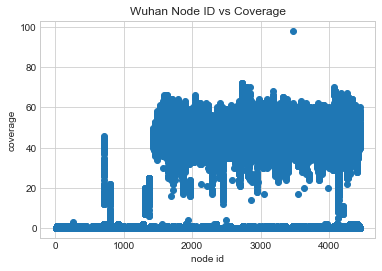

In [5]:
plt.scatter(wuhan_data['node.id'], wuhan_data['coverage']) 
plt.title('Wuhan Node ID vs Coverage')
plt.xlabel('node id')
plt.ylabel('coverage')

### Ebola

Text(0, 0.5, 'coverage')

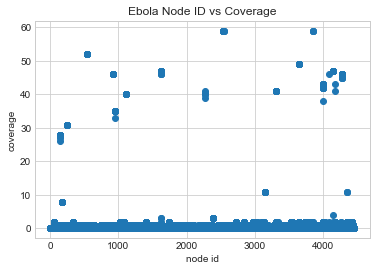

In [6]:
plt.scatter(ebola_data['node.id'], ebola_data['coverage']) 
plt.title('Ebola Node ID vs Coverage')
plt.xlabel('node id')
plt.ylabel('coverage')

### Conclusion from visualization

 1. Ebola reads have a much lower coverage compared to the wuhan corona virus reads
 2. Ebola coverage is somewhat evenly spread out throughout the nodes while the wuhan reads start at around 700

## PCA

### Combine

Combine the Wuhan and Ebola reads

In [7]:
# We can transpose the full DataFrame to swap rows and columns `data.T`
comb = pd.DataFrame([wuhan_data[wuhan_data.columns[-1]].T, ebola_data[ebola_data.columns[-1]].T], 
                    index=["isolate_"  + str(i) for i in range(2)])
display(comb)

,0,1,2,3,4,5,6,7,8,9,...,73856,73857,73858,73859,73860,73861,73862,73863,73864,73865
isolate_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
isolate_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Scale

Scale the data to have a mean of 0 and a variance of 1

In [8]:
from sklearn.preprocessing import StandardScaler
comb_scaled = StandardScaler().fit_transform(comb)

### Perform PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
principalComponents = pca.fit_transform(comb_scaled)

In [10]:
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1'],
                           index=["isolate_"  + str(i) for i in range(2)])

labels = pd.DataFrame(["WuHan", "Ebola"], 
                      columns = ['labels'],
                      index=["isolate_"  + str(i) for i in range(2)])

# display(labels)
# display(principalDf)
finaldf = pd.concat([principalDf, labels[['labels']]], axis=1)
display(finaldf)

,principal component 1,labels
isolate_0,178.913387,WuHan
isolate_1,-178.913387,Ebola


As you can see from the table above, principal component 1 seperates the ebola and WuHan reads by a 356 points.

### Visualize

Text(0, 0.5, 'principal component')

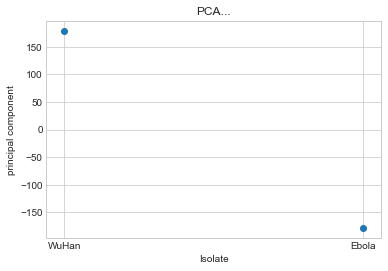

In [11]:
plt.scatter(finaldf['labels'], finaldf['principal component 1']) 

# targets = ['isolate_0', 'isolate_1']
# plt.legend((line1, line2, line3), ('label1', 'label2', 'label3'))
plt.title('PCA...')
plt.xlabel('Isolate')
plt.ylabel('principal component')


## Distance matrix
Generate a distance matrix

In [12]:
from scipy.spatial import distance_matrix
df = principalDf

In [13]:
distance_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)

## Neighbour joining

In [34]:
distance_matrix

,isolate_0,isolate_1
isolate_0,0.000000,357.826774
isolate_1,357.826774,0.000000


In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist

In [41]:
# Condense the distance matrix
condensed = pdist(distance_matrix)

In [42]:
Z = linkage(condensed)

{'icoord': [[5.0, 5.0, 15.0, 15.0]],
 'dcoord': [[0.0, 506.0434763930868, 506.0434763930868, 0.0]],
 'ivl': ['isolate_0', 'isolate_1'],
 'leaves': [0, 1],
 'color_list': ['b']}

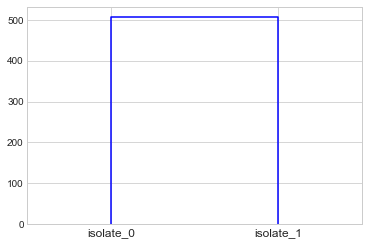

In [44]:
dendrogram(Z,
          labels=["isolate_0", "isolate_1"])